In [1]:
import nemo.collections.asr as nemo_asr
import torch

# Chạy trên CPU (hoặc thay 'cpu' bằng 'cuda' nếu có GPU)
device = torch.device('cpu')

# Load model
model = nemo_asr.models.EncDecRNNTBPEModel.restore_from("Model-vi-10.nemo", map_location=device)
model.to(device)
model.eval()


/home/trang/Documents/parakeet_finetuned/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/trang/Documents/parakeet_finetuned/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OneLogger: Setting error_handling_strategy to DISABLE_QUIETLY_AND_REPORT_METRIC_ERROR for rank (rank=0) with OneLogger disabled. To override: explicitly set error_handling_strategy parameter.
No exporters were provided. This means that no telemetry data will be collected.


[NeMo I 2025-11-06 17:31:29 mixins:184] Tokenizer SentencePieceTokenizer initialized with 6000 tokens


[NeMo W 2025-11-06 17:31:34 modelPT:188] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: manifests/train_manifest.json
    sample_rate: 16000
    batch_size: 4
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: true
    trim_silence: true
    max_duration: 16.7
    min_duration: 0.1
    is_tarred: false
    tarred_audio_filepaths: null
    shuffle_n: 2048
    bucketing_strategy: fully_randomized
    bucketing_batch_size: null
    
[NeMo W 2025-11-06 17:31:34 modelPT:195] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: manifests/val_manifest.json
    sample_rate: 16000
    batch_size: 4


[NeMo I 2025-11-06 17:31:34 features:306] PADDING: 0
[NeMo I 2025-11-06 17:31:45 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}
[NeMo I 2025-11-06 17:31:45 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-11-06 17:31:46 rnnt_greedy_decoding:679] Cannot use decoder with CUDA graphs, reason: Cannot instantiate RNNTGreedyDecodeCudaGraph without `pip install cuda-python`


[NeMo I 2025-11-06 17:31:46 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-11-06 17:31:46 rnnt_greedy_decoding:679] Cannot use decoder with CUDA graphs, reason: Cannot instantiate RNNTGreedyDecodeCudaGraph without `pip install cuda-python`


[NeMo I 2025-11-06 17:32:34 save_restore_connector:282] Model EncDecRNNTBPEModel was successfully restored from /home/trang/Documents/parakeet_finetuned/Model-vi-10.nemo.


EncDecRNNTBPEModel(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConformerEncoder(
    (pre_encode): ConvSubsampling(
      (out): Linear(in_features=2560, out_features=1024, bias=True)
      (conv): MaskedConvSequential(
        (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        (3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (4): ReLU(inplace=True)
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        (6): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (7): ReLU(inplace=True)
      )
    )
    (pos_enc): RelPositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-41): 42 x ConformerLayer(
        (norm_feed_forward1): LayerNorm((1024,), eps=1e-0

In [3]:
import json 
from jiwer import wer
import pandas as pd 
import os
import shutil

val_manifest = "manifests/val_manifest.json"


def evaluate_model(val_manifest, output_dir="evaluation"):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    audiofiles = []
    hyps = []
    refs = []

    with open(val_manifest, 'r', encoding='utf-8') as f:
        for line in f:
            row = json.loads(line)
            audiofiles.append(row['audio_filepath'])
            refs.append(row['text'])

    hyps = model.transcribe(audiofiles)
    df = pd.DataFrame({"audio_filepath": audiofiles, "hypothesis": hyps, "reference": refs})
    df.to_csv(os.path.join(output_dir, "transcriptions.csv"), index=False)
    overall_wer = wer(refs, hyps)
    print(f"Overall WER: {overall_wer:.4f}")
    return overall_wer
    


In [5]:
%%time
hyps = model.transcribe(["data/033_000402.wav"])
ref = "vâng và một câu hỏi đã được đặt ra từ lâu mà vẫn chưa có lời giải đó là chúng ta có nên dừng sản xuất lúa vụ ba tại đồng bằng sông cửu long hay không và nếu dừng thì là khi nào hãy cùng lắng nghe những người trong cuộc"
print("Hypothesis:", hyps[0])
print("Reference:", ref)

Transcribing: 100%|██████████| 1/1 [00:06<00:00,  6.81s/it]

Hypothesis: Hypothesis(score=-5.864361002804799, y_sequence=tensor([ 978,  175,   44,  372,  422,   87,   62,  774,  128,  134,  599,   85,
         389,  407,   35,  697,   94,   24,  152,  164,   35,  327,  344,  399,
         363,  172,  168,  208,  420, 1015,  346,   54,   31,  402,   76,   24,
         150,  268,  682,  281,   24,   72,   66,   64,  314]), text='vâng vào một câu hỏi đã được đặt ra từ đâu mà vẫn chưa có lợi đó là chúng ta có nên sản xuất vụ ba tại đầu bằng sông hay không và nếu thì là khi nào hãy cùng là những người trong cuộc', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngram_lm_state=None, tokens=None, last_token=None, token_duration=None, last_frame=None)
Reference: vâng và một câu hỏi đã được đặt ra từ lâu mà vẫn chưa có lời giải đó là chúng ta có nên dừng sản xuất lúa vụ ba tại đồng bằng sông cửu long hay không và nếu dừng thì 

In [7]:
%%time
hyps = model.transcribe(["data/033_000402.wav"])

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Transcribing: 100%|██████████| 1/1 [00:07<00:00,  7.49s/it]

CPU times: user 1min 44s, sys: 467 ms, total: 1min 45s
Wall time: 7.6 s


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.read_csv('log.csv', index_col='epoch')
data

,val_loss,train_loss
epoch,,
0,0.549039,1.201454
1,0.336038,0.515220
2,0.355118,0.369274
3,0.305572,0.268095
4,0.323353,0.219804
5,0.346659,0.131075
6,0.442260,0.124784
7,0.367159,0.106487
8,0.424517,0.070704


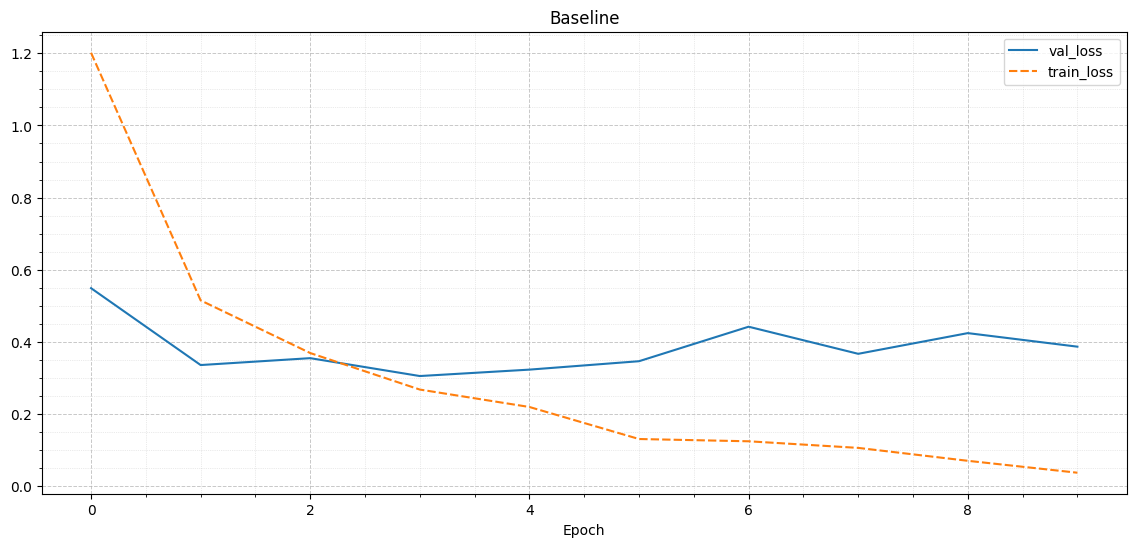

In [5]:
plt.figure(figsize=(14,6))
plt.title('Baseline')
sns.lineplot(data=data)
plt.xlabel('Epoch')
plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)

# Có thể chia ô lớn theo major ticks
plt.minorticks_on()
plt.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.5)

plt.show()

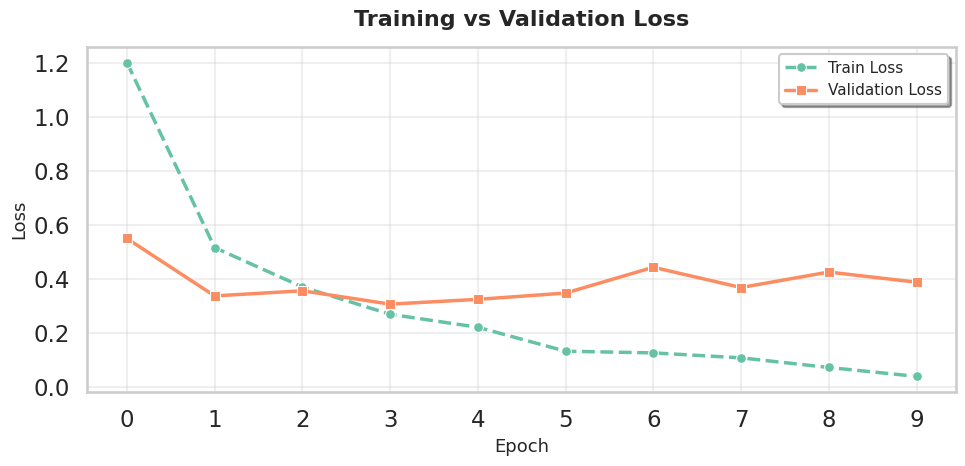

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Đọc dữ liệu
data = pd.read_csv('log.csv', index_col='epoch')

# Thiết lập style
sns.set_theme(style="whitegrid", context="talk", palette="Set2")

plt.figure(figsize=(10, 5))
plt.title("Training vs Validation Loss", fontsize=16, fontweight='bold', pad=15)

# Vẽ các đường
sns.lineplot(data=data, x=data.index, y='train_loss', label='Train Loss',
             linestyle='--', marker='o', linewidth=2.5, markersize=7)
sns.lineplot(data=data, x=data.index, y='val_loss', label='Validation Loss',
             linestyle='-', marker='s', linewidth=2.5, markersize=7)

# Tìm min val_loss để annotate
best_epoch = data['val_loss'].idxmin()
best_val = data.loc[best_epoch, 'val_loss']



# Cấu hình trục và grid
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.xticks(data.index)
plt.grid(alpha=0.3)
plt.legend(fontsize=11, frameon=True, shadow=True)
plt.tight_layout()
plt.show()
